In [11]:
import os
import numpy as np
import pandas as pd
import librosa
import parselmouth
from scipy.signal import lfilter
from python_speech_features import mfcc, delta
from parselmouth.praat import call
from numpy.linalg import lstsq

In [12]:
data_dir = "PD_Detection"
output_csv = "voice_features_final.csv"

In [24]:
def extract_jitter_shimmer_hnr_f0(y, sr):
    try:
        snd = parselmouth.Sound(y, sr)
        point_process = call(snd, "To PointProcess (periodic, cc)", 75, 500)

        jitter = call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        shimmer = call([snd, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        hnr_obj = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr_value = hnr_obj.get_value(0.0)  

        pitch = call(snd, "To Pitch", 0.0, 75, 15)
        f0_mean = call(pitch, "Get mean", 0, 0, "Hertz")

        if np.isnan(f0_mean):
            f0_mean = 0.0

        return jitter, shimmer, hnr_value, f0_mean

    except Exception as e:
        print(f"Pitch/HNR extraction failed: {e}")
        return 0.0, 0.0, 0.0, 0.0

In [14]:
def extract_mfcc(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs, axis=1)

In [15]:
def extract_gfcc(y, sr):
    gfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(gfccs, axis=1)

In [16]:
def extract_lpc(y, sr, order=13):
    N = len(y)
    A = np.zeros((N - order, order))
    for i in range(order):
        A[:, i] = y[order - i - 1:N - i - 1]
    b = y[order:]
    coeffs, _, _, _ = lstsq(A, b, rcond=None)
    return coeffs[:order]

In [17]:
def extract_lpcc(lpc_coeffs, order=13):
    lpcc = np.zeros(order)
    for n in range(order):
        lpcc[n] = lpc_coeffs[n] if n < len(lpc_coeffs) else 0
    return lpcc

In [18]:
data = []
success = 0
fail_log = []

for label in ['Healthy', 'PD']:
    folder = os.path.join(data_dir, label)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_path = os.path.join(folder, file)
            print(f"Processing: {file_path}")
            try:
                y, sr = librosa.load(file_path, sr=None)

                mfcc_feats = extract_mfcc(y, sr)
                gfcc_feats = extract_gfcc(y, sr)
                lpc_feats = extract_lpc(y, sr)
                lpcc_feats = extract_lpcc(lpc_feats)
                jitter, shimmer, hnr, f0 = extract_jitter_shimmer_hnr_f0(y, sr)
                features = np.concatenate([mfcc_feats, gfcc_feats, lpc_feats, lpcc_feats,
                                           [jitter, shimmer, hnr, f0]])
                data.append(np.append(features, label))
                success += 1
            except Exception as e:
                print(f"Failed on {file}: {e}")
                fail_log.append((file_path, str(e)))

Processing: PD_Detection/Healthy/AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2.wav
Processing: PD_Detection/Healthy/AH_292J_201CB911-31C1-4CD0-BD73-4FBA4A16C21F.wav
Processing: PD_Detection/Healthy/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.wav
Processing: PD_Detection/Healthy/AH_264Z_593C20CD-0A54-4177-B031-26EE147080A3.wav
Processing: PD_Detection/Healthy/AH_197T_7552379A-2310-46E1-9466-9D8045C990B8.wav
Processing: PD_Detection/Healthy/AH_195B_39DA6A45-F4CC-492A-80D4-FB79049ACC22.wav
Processing: PD_Detection/Healthy/AH_222K_FC9D2763-1836-460B-954F-37F23D6CD81D.wav
Processing: PD_Detection/Healthy/AH_325J_7F5F27AA-5A93-43CF-AB17-FC53940BF4B0.wav
Processing: PD_Detection/Healthy/AH_333L_6C551A6E-CC47-410E-AA49-2DC0A86E6489.wav
Processing: PD_Detection/Healthy/AH_325A_3EB21DC7-C340-4D0E-AC9E-0EABF217BBEE.wav
Processing: PD_Detection/Healthy/AH_322A_C3BF5535-A11E-498E-94EB-BE7E74099FFB.wav
Processing: PD_Detection/Healthy/AH_114S_A89F3548-0B61-4770-B800-2E26AB3908B6.wav
Processing: PD_D

In [19]:
columns = (
    [f"MFCC_{i+1}" for i in range(13)] +
    [f"GFCC_{i+1}" for i in range(13)] +
    [f"LPC_{i+1}" for i in range(13)] +
    [f"LPCC_{i+1}" for i in range(13)] +
    ["Jitter", "Shimmer", "HNR", "F0", "Label"]
)

df = pd.DataFrame(data, columns=columns)
df.to_csv(output_csv , index=False)

print(f"\nExtraction complete: {success} files processed successfully.")
print(f"Failed files: {len(fail_log)}")
if fail_log:
    print("First few failed files:")
    for f, err in fail_log[:5]:
        print(f"  - {f}: {err}")


Extraction complete: 26 files processed successfully.
Failed files: 0


In [20]:
import pandas as pd
df = pd.read_csv("voice_features_final.csv")
print(df.shape)
print(df['Label'].value_counts())

(26, 57)
Label
Healthy    13
PD         13
Name: count, dtype: int64


In [21]:
import pandas as pd

df = pd.read_csv("voice_features_final.csv")

df.dropna(axis=1, how="all", inplace=True)

df = df.dropna()

print("Final shape:", df.shape)
print("Columns:", df.columns.tolist())

X = df.drop(columns=["Label"])
y = df["Label"].map({"Healthy": 0, "PD": 1})

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

model = SVC(kernel="rbf", C=1.0)
model.fit(X_train, y_train)

joblib.dump(model, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print(" Model and scaler saved successfully.")

Final shape: (26, 56)
Columns: ['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'GFCC_1', 'GFCC_2', 'GFCC_3', 'GFCC_4', 'GFCC_5', 'GFCC_6', 'GFCC_7', 'GFCC_8', 'GFCC_9', 'GFCC_10', 'GFCC_11', 'GFCC_12', 'GFCC_13', 'LPC_1', 'LPC_2', 'LPC_3', 'LPC_4', 'LPC_5', 'LPC_6', 'LPC_7', 'LPC_8', 'LPC_9', 'LPC_10', 'LPC_11', 'LPC_12', 'LPC_13', 'LPCC_1', 'LPCC_2', 'LPCC_3', 'LPCC_4', 'LPCC_5', 'LPCC_6', 'LPCC_7', 'LPCC_8', 'LPCC_9', 'LPCC_10', 'LPCC_11', 'LPCC_12', 'LPCC_13', 'Jitter', 'Shimmer', 'F0', 'Label']
 Model and scaler saved successfully.


In [22]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("voice_features_final.csv")
X = df.drop(columns=["Label", "HNR"])
y_true = df["Label"]

scaler = joblib.load("scaler.pkl")
model = joblib.load("svm_model.pkl")

X_scaled = scaler.transform(X)

y_pred = model.predict(X_scaled)

label_map = {0: "Healthy", 1: "PD"}
decoded_pred = [label_map[i] for i in y_pred]

for i, (true_label, pred_label) in enumerate(zip(y_true, decoded_pred)):
    print(f"Sample {i+1}: True = {true_label}, Predicted = {pred_label}")

print("\nClassification Report:")
print(classification_report(y_true, decoded_pred))
print("Accuracy:", accuracy_score(y_true, decoded_pred))

Sample 1: True = Healthy, Predicted = Healthy
Sample 2: True = Healthy, Predicted = Healthy
Sample 3: True = Healthy, Predicted = Healthy
Sample 4: True = Healthy, Predicted = Healthy
Sample 5: True = Healthy, Predicted = Healthy
Sample 6: True = Healthy, Predicted = Healthy
Sample 7: True = Healthy, Predicted = Healthy
Sample 8: True = Healthy, Predicted = Healthy
Sample 9: True = Healthy, Predicted = Healthy
Sample 10: True = Healthy, Predicted = Healthy
Sample 11: True = Healthy, Predicted = PD
Sample 12: True = Healthy, Predicted = Healthy
Sample 13: True = Healthy, Predicted = Healthy
Sample 14: True = PD, Predicted = PD
Sample 15: True = PD, Predicted = PD
Sample 16: True = PD, Predicted = Healthy
Sample 17: True = PD, Predicted = PD
Sample 18: True = PD, Predicted = PD
Sample 19: True = PD, Predicted = PD
Sample 20: True = PD, Predicted = PD
Sample 21: True = PD, Predicted = PD
Sample 22: True = PD, Predicted = PD
Sample 23: True = PD, Predicted = PD
Sample 24: True = PD, Predic

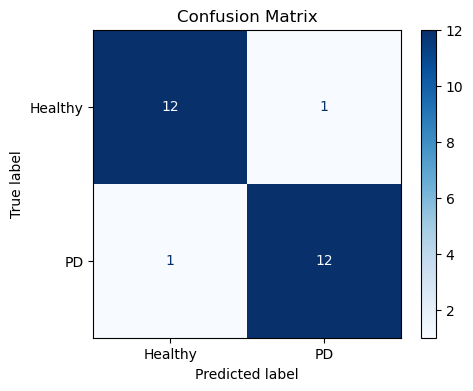

In [23]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = pd.read_csv("voice_features_final.csv")

X = df.drop(columns=["Label", "HNR"])
y_true = df["Label"].map({"Healthy": 0, "PD": 1})

scaler = joblib.load("scaler.pkl")
model = joblib.load("svm_model.pkl")

X_scaled = scaler.transform(X)
y_pred = model.predict(X_scaled)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "PD"])

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()